**Option 1 - Data Science/ML** 

---
**Objectives**

1. To gain insights from the dataset to make orgainzed data-driven decisions. 
2. Topic Modeling - to extract topics from a large volume of data
3. Design a simple model to predict the number of upVotess based on the time and contents of the title.
---
**Pipeline**

1. Data Cleaning : Data cleaning can be performed in many different ways and not limited to the steps followed below. It is an important step that the helps identify relevant instances.
2. Feature Engineering : It helps transform data into features that accuractely reflect the relation to predictive models.
3. Data Visualization : This technique helps draw insights from the dataset. Very useful as it helps articulate the task at hand.
( Posts vs Time ; Popular authors ; best time to post news ; word embedding ) 
4. Text Understanding
5. Topic Modeling : LDA
6. Linear Regression
---



**Importing Libraries and Reading Dataset**

In [ ]:
pip install geotext

In [ ]:
import pandas as pd
import numpy as np 
import seaborn as sns
sns.set()
from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt
%matplotlib inline
import string
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')
from contextlib import contextmanager
import time
from geotext import GeoText
import re
from collections import Counter
from nltk.corpus import stopwords
import nltk
from nltk.stem import PorterStemmer,WordNetLemmatizer
from wordcloud import WordCloud

# Importing dataset
df=pd.read_csv('/content/drive/MyDrive/Eluvio-DS Challenge/Eluvio_DS_Challenge.csv') 
print("Shape of data=>",df.shape)

Shape of data=> (509236, 8)


In [ ]:
df.info()
df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509236 entries, 0 to 509235
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   time_created  509236 non-null  int64 
 1   date_created  509236 non-null  object
 2   up_votes      509236 non-null  int64 
 3   down_votes    509236 non-null  int64 
 4   title         509236 non-null  object
 5   over_18       509236 non-null  bool  
 6   author        509236 non-null  object
 7   category      509236 non-null  object
dtypes: bool(1), int64(3), object(4)
memory usage: 27.7+ MB


,time_created,date_created,up_votes,down_votes,title,over_18,author,category
0,1201232046,2008-01-25,3,0,Scores killed in Pakistan clashes,False,polar,worldnews
1,1201232075,2008-01-25,2,0,Japan resumes refuelling mission,False,polar,worldnews
2,1201232523,2008-01-25,3,0,US presses Egypt on Gaza border,False,polar,worldnews
3,1201233290,2008-01-25,1,0,Jump-start economy: Give health care to all,False,fadi420,worldnews
4,1201274720,2008-01-25,4,0,Council of Europe bashes EU&UN terror blacklist,False,mhermans,worldnews


# **1.Data Cleaning**

**a. Check for missing values**

Let’s see if there are any null values present in our dataset. 

In [ ]:
df.isnull().sum()

time_created    0
date_created    0
up_votes        0
down_votes      0
title           0
over_18         0
author          0
category        0
dtype: int64

No null values present. 

**b.Feature Exploration**

There are a total of 10 features present in the dataset. 

False    508916
True        320
Name: over_18, dtype: int64


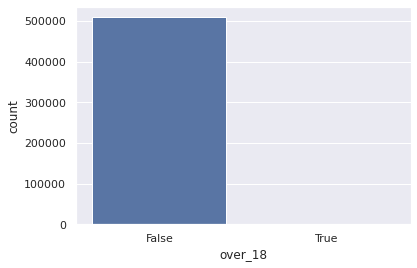

In [ ]:
sns.countplot(df['over_18'])
print(df['over_18'].value_counts())

In [ ]:
print(df['category'].value_counts())
print(df['down_votes'].value_counts()) 


worldnews    509236
Name: category, dtype: int64
0    509236
Name: down_votes, dtype: int64


--> All down_votes are zero

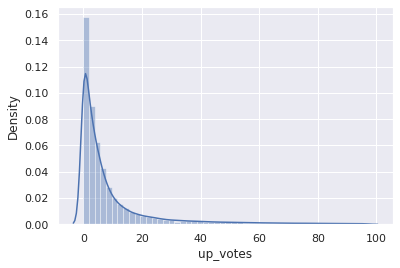

In [ ]:
sns.distplot(df[df['up_votes']<=97]['up_votes'])

-->It can be observed that upVotes have zero-inflated distribution and 18% of news have no upvotes.





**Length of the title**

In [ ]:
for t, title in enumerate(df[['title']].sample(20, random_state=2019).title):
    print(t, ':', title)

0 : Iran launches mass production of new surface-to-air missiles
1 : Burkina Faso traders riot over lootings: Merchants set fire to ruling party s headquarters after officials fail to stop soldiers ransacking their shops

2 : Drought, hail, cold conspire to turn European wine grape harvest in worst in half a century
3 : Pinochet-era death squad members jailed
4 : Peru state energy company reports Amazon oil spill
5 : Miami feds indict 6 on charges of supporting Pakistani Taliban
6 : Ukrainian rebels free four OSCE hostages, four still in captivity
7 : Signs of Changes Taking Hold in Electronics Factories in China

8 : Turnbull, Morrison to speak on tax reform
9 : Panama Papers: Pakistan PM Sharif under fire over offshore accounts
10 : Germany Pushes for Gas Pipeline with Russia
11 : China eyes artificial intelligence for ‘fire-and-forget’ cruise missiles | China is already a global leader in the field of using artificial intelligence in missiles, says representative of space programme 

--> Note that "length of titles" does not really give much information

**Over_18 contents**

In [ ]:
df.over_18.value_counts()

False    508916
True        320
Name: over_18, dtype: int64

In [ ]:
for text in df[df.over_18==True].sample(20, random_state=2019).title:
    print(text)

International Go-Topless Day sees women bare breasts in 50 cities
NSFW: Syrian Internet Restored, Dramatic Footage Emerges [VIDEO]
 Muslim, let s get naked : Ukraine-based activist group Femen Opens First Office Abroad in Paris. For the opening, the women ran half-naked through a predominantly Muslim neighborhood in the French capital.
In pictures: Gaza Massacre (Graphic!  possibly NSFW)
Footage suggests Egypt protesters shot at - NSFW
Tragic story - How the Thai army deals with deserters. Warning - graphic pictures inside.
IDF kills young Palestinian boy. Potentially NSFW.
Tibetan in Delhi Sets Self Alight to Protest Chinese Leader s Visit - NYTimes.com
[NSFL] Australian child molester Peter Scully faces death penalty in Philippines - Scully  filmed his torture and rape of young girls as he made them dig their own graves  and  laughed, joked and acted nonchalant about his alleged crimes 
2,500 people killed in Bangladesh by the Govt. on May 6, 2013, however, the World doesn t know abo

--> Contents containing terms like [NSFW, NSFL, NPR] are all classified as over_18

**Content vs Time**

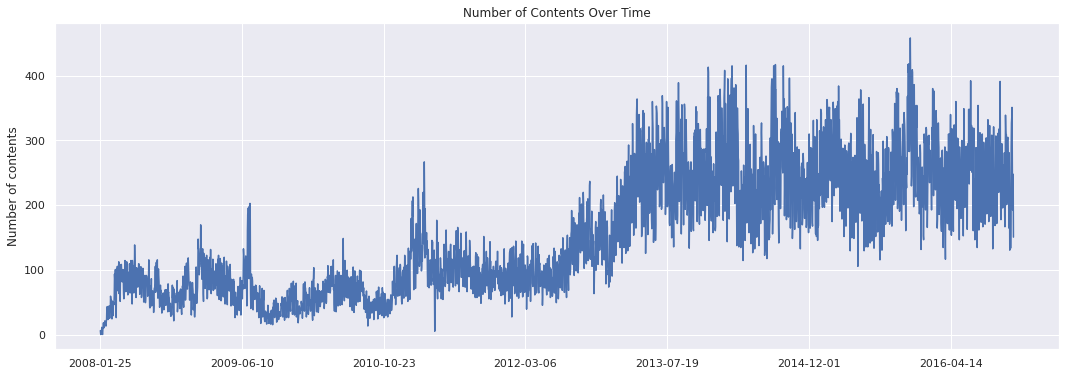

In [ ]:
df[['date_created', 'time_created']].groupby('date_created').count().plot(figsize=(18,6), legend=None)
plt.title('Number of Contents Over Time')
plt.ylabel('Number of contents')
plt.xlabel(None)
plt.show()

# **2. Feature Engineering:**


In [ ]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))
    
def places(x):
    count = GeoText(x).countries
    city = GeoText(x).cities
    w = 0
    if not count and not city: return 0
    else:
        w=len(count)+len(city)
        return w 

def countries(x):
    count = GeoText(x).countries
    city = GeoText(x).cities
    w = ''
    if not count and not city: return np.nan
    else:
        for country in count:
            w = w+' '+country
        for c in city:
            w = w+' '+c
        return w


def df_feature_engineer(df):
    df['date_created'] = pd.to_datetime(df['date_created'])
    df['day_of_week']=df['date_created'].dt.day_name()
    df['day_of_week_num']=df['date_created'].dt.dayofweek
    df['year'] = df['date_created'].dt.year
    df['month'] = df['date_created'].dt.month
    df['day'] = df['date_created'].dt.day
    df['weekend'] = np.where(df['date_created'].dt.dayofweek>4,1, 0)
    df['years_to_now'] = (datetime.today() - df['date_created']).dt.days/365
    df['time_created'] = pd.to_datetime(df['time_created'], unit='s')
    df['day_time']=df['time_created'].dt.hour+df['time_created'].dt.minute/60+df['time_created'].dt.second/3600
    df['author_total_posts'] = df['author'].groupby(df['author']).transform('count')
    df = df.drop(columns=['date_created','down_votes','category'])
    df['title_length'] = df['title'].str.split().apply(len)
    df['over_18'] = df['over_18'].map({False:0,True:1})
    df['countries'] = df['title'].apply(lambda x: countries(x))
    df['places'] = df['title'].apply(lambda x: places(x))
    return df


In [ ]:
with timer("New Features and Clean Data"):
    df = df_feature_engineer(df)

New Features and Clean Data - done in 36s


Formatted Data

In [ ]:
df = df.sort_values(['time_created'], ascending=True)
df.head(1)

,time_created,up_votes,title,over_18,author,day_of_week,day_of_week_num,year,month,day,weekend,years_to_now,day_time,author_total_posts,title_length,countries,places
0,2008-01-25 03:34:06,3,Scores killed in Pakistan clashes,0,polar,Friday,4,2008,1,25,0,13.243836,3.568333,50,5,Pakistan,1




---



# **3. Data Visualization**

**1. Countplots: Number of posts vs year and day of the week.**

Text(0.5, 1.0, 'Num of posts vs Year')

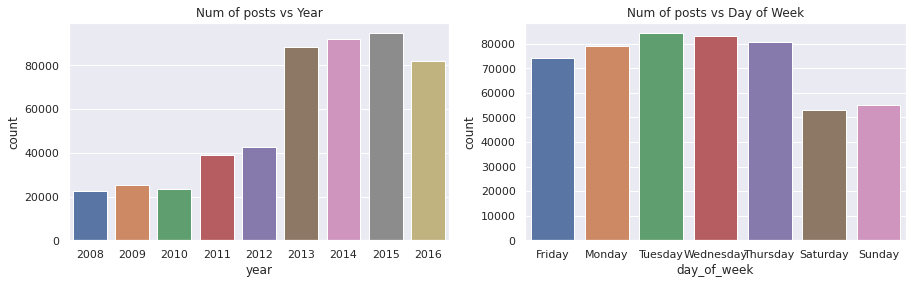

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(15, 4))
g=sns.countplot(x='day_of_week',data=df,ax=ax[1])
g.set_title('Num of posts vs Day of Week')
g=sns.countplot(x='year',data=df,ax=ax[0])
g.set_title('Num of posts vs Year')

**2. Barplots: Average upvotes vs year and day of the week.**

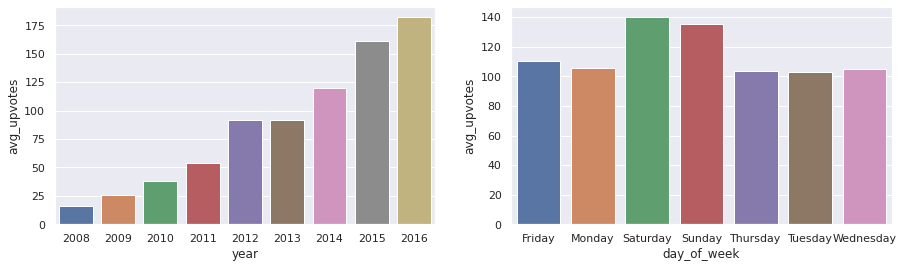

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(15, 4))
plot1 = df.groupby('year').mean()['up_votes'].reset_index(name='avg_upvotes')
sns.barplot(x='year',y='avg_upvotes',data=plot1, ax=ax[0])
plot2 = df.groupby('day_of_week').mean()['up_votes'].reset_index(name='avg_upvotes')
sns.barplot(x='day_of_week',y='avg_upvotes',data=plot2, ax=ax[1])

--> From the plots, it can be observed that the number of visitors and posts increase over time. Users tend to be more active.From this, it would quite reasonable to assume that any posts during the weekend receives more upvotes on average.

**3. Total upvotes and mean upvotes vs day time.**


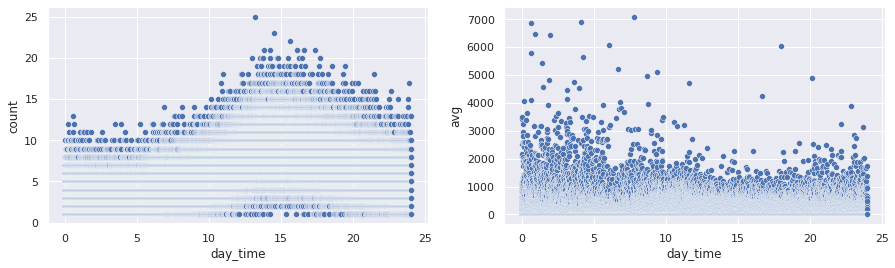

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(15, 4))
plot3 = df.groupby('day_time').count()['up_votes'].reset_index(name='count')
sns.scatterplot(x='day_time', y='count', data=plot3, ax=ax[0])
plot4 = df.groupby('day_time').mean()['up_votes'].reset_index(name='avg')
sns.scatterplot(x='day_time', y='avg', data=plot4, ax=ax[1])

--> From the above plot it can be seen that one post in particular received the highest upvotes. Additionally, threre are more posts after 3:00pm.


In [ ]:
#df[df['up_votes'] > 20000] # Comment this line when performing regression


**4. Top 30 most active authors and top 30 authors with most upvotes.**

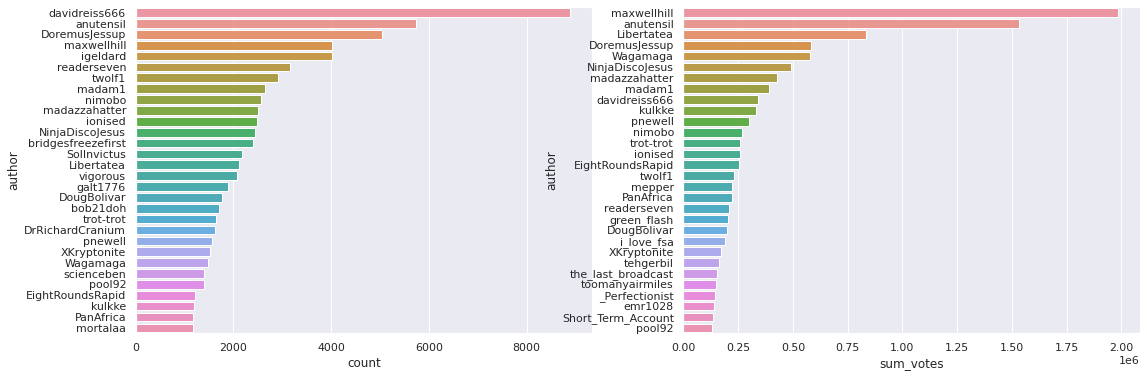

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(18, 6))
num = 30
sns.countplot(y=df['author'],\
              order = df['author'].value_counts().iloc[:num].index, ax=ax[0])

plot5 = df.groupby('author').sum()['up_votes'].reset_index(name='sum_votes').\
       sort_values(by='sum_votes',ascending=False)
sns.barplot(y='author',x='sum_votes',data=plot5.iloc[:num],ax=ax[1])

**5. Distribution of the length of the news title. Avg votes vs length of news titles.**


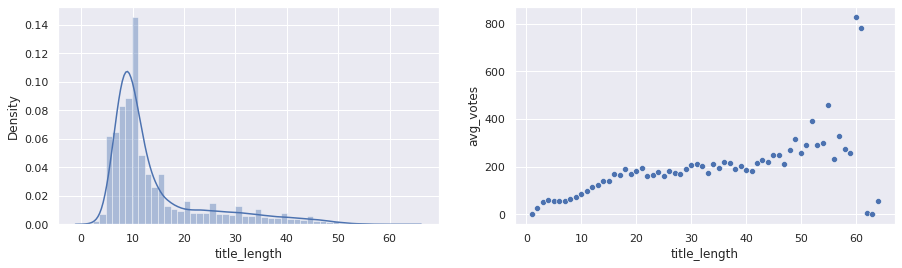

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(15, 4))
sns.distplot(df['title_length'],ax=ax[0])
plot6 = df.groupby('title_length').mean()['up_votes'].reset_index(name='avg_votes')
sns.scatterplot(plot6['title_length'],plot6['avg_votes'],ax=ax[1])

--> We can see that when the length of the words is around 12, there is a peak in the number of upvotes but gradually decreases with the increase in word length and almost reaches zero after 55. 

**6. Top 30 countries in the news with different years.**

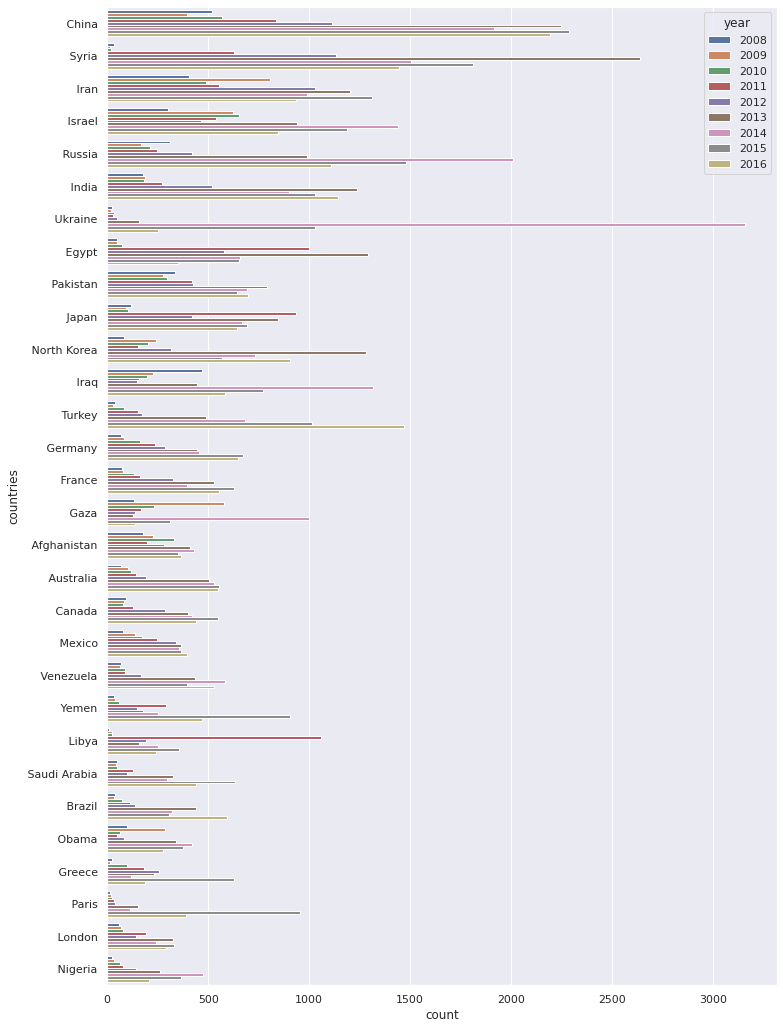

In [ ]:
fig = plt.figure(figsize=(12,18))
sns.countplot(y=df['countries'],\
              order = df['countries'].value_counts().iloc[:30].index, hue=df['year'])

--> Not enough can be inferred from the this plot. We can see that the countries mentioned differ year by year. For example, we can see that there count for Ukraine increased in 2014 due to [Ukraine's Revolution](https://www.bbc.com/news/world-europe-30131108)



---



# **4. Text Understanding**

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

a. Word cleaning and lemmatization

In [ ]:
text = df['title']

lemma=WordNetLemmatizer() 
stopwords_en = stopwords.words('english')


def text_process(text):
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", "", text)
    text = re.sub(r"U-turn", "Uturn", text)
    text = re.sub(r"New York Times", "NewYorkTimes", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"U of", "University of", text)
    text = re.sub(r"N Korea", "NorthKorea", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r"U S", "US", text)
    text = re.sub(r"U S ", "US", text)
    text = re.sub(r"U N", "UN", text)
    text = re.sub(r"U N ", "UN", text)
    text = re.sub(r"@\S+", "", text)

    word=nltk.word_tokenize(text.lower())
    new_word=[w for w in word if w not in stopwords_en and w.isalpha()]
    new_word=[lemma.lemmatize(w, "v") for w in new_word]
    return new_word

print('='*50)
print(text[381])
print('='*50)
print(text_process(text[381]))

 Iran Defiant Ahead of U.N. Nuclear Watchdog Report
['iran', 'defiant', 'ahead', 'un', 'nuclear', 'watchdog', 'report']


After applying tokenization and normalization

In [ ]:
def word_freq(s):
    txt = s.str.lower().str.cat(sep=' ')  
    words = text_process(txt)
    words_dist = nltk.FreqDist(w for w in words) 
    return words_dist

for year in range(2008, 2017):
    words_dist=word_freq(df[df['year']==year]['title'])
    res=[]
    for w, count in words_dist.most_common(10): res.append(w)
    print(year, res)

2008 ['us', 'say', 'kill', 'china', 'war', 'world', 'attack', 'iraq', 'iran', 'new']
2009 ['us', 'israel', 'iran', 'say', 'gaza', 'kill', 'world', 'war', 'new', 'israeli']
2010 ['us', 'israel', 'say', 'kill', 'world', 'china', 'new', 'iran', 'war', 'attack']
2011 ['say', 'kill', 'us', 'protest', 'libya', 'egypt', 'new', 'china', 'government', 'force']
2012 ['say', 'kill', 'us', 'china', 'syria', 'iran', 'new', 'news', 'police', 'attack']
2013 ['say', 'us', 'syria', 'kill', 'china', 'new', 'attack', 'world', 'police', 'korea']
2014 ['say', 'us', 'ukraine', 'russia', 'kill', 'new', 'china', 'state', 'attack', 'russian']
2015 ['say', 'us', 'kill', 'china', 'attack', 'new', 'russia', 'state', 'isis', 'syria']
2016 ['say', 'us', 'china', 'kill', 'attack', 'new', 'syria', 'russia', 'state', 'police']


In [ ]:
words_dist=word_freq(df['title'])
len(words_dist)
#words_dist

72208

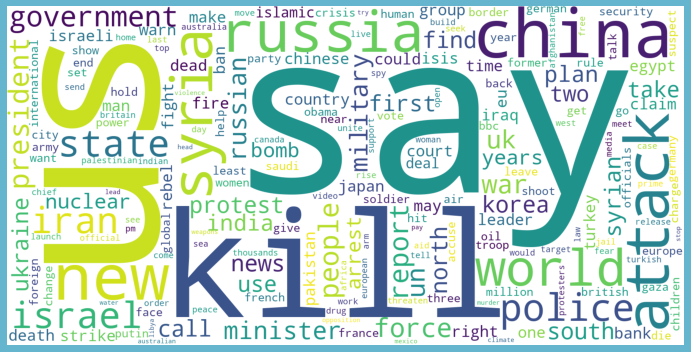

5729

In [ ]:
wordcloud = WordCloud(width=1600, height=800,background_color='white').generate_from_frequencies(words_dist)
fig = plt.figure(figsize=(15,5), facecolor='c')
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout()
plt.show()
words_dist['bbc']

**Word2Vec Embedding**

In [ ]:
import gensim
filename = '/content/drive/MyDrive/Eluvio-DS Challenge/GoogleNews-vectors-negative300.bin.gz'
model = gensim.models.KeyedVectors.load_word2vec_format(filename, binary=True)

In [ ]:
def Word2Vec(model, titles_list):
    big_title_string = ' '.join(titles_list)
    words = text_process(big_title_string)
    vectorList = [model[word] for word in words if word in model.vocab]
    wordsFiltered = [word for word in words if word in model.vocab]
    wrd2vec_dict = dict(zip(wordsFiltered, vectorList))
    dic = pd.DataFrame.from_dict(wrd2vec_dict, orient='index')
    print('Shape of dictionary',dic.shape)
    return dic

In [ ]:
titles_list = [title for title in text]
dic = Word2Vec(model, titles_list)

Shape of dictionary (38301, 300)


***t-Distributed Stochastic Neighbor Embedding (t-SNE)***- It is non-linear dimensionality reduction technqiue that is particularly helpful for high-dimensinoal datasets. It can be used in image processing, speech processing, genomic data and Natural Language Processing.

In [ ]:
pip install adjustText

424

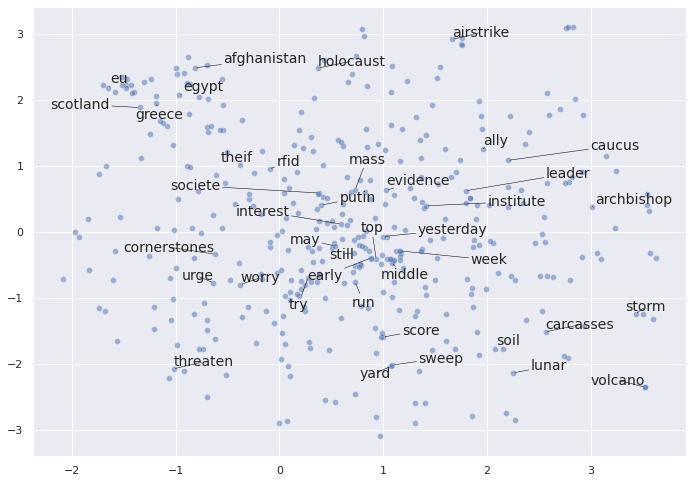

In [ ]:
from sklearn.manifold import TSNE
from adjustText import adjust_text
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)
tsne_df = tsne.fit_transform(dic[0:400])

fig, ax = plt.subplots(figsize = (11.7, 8.27))
sns.scatterplot(tsne_df[:, 0], tsne_df[:, 1], alpha = 0.5)
texts = []
words_to_plot = list(np.arange(0, 400, 10))
for word in words_to_plot: texts.append(plt.text(tsne_df[word, 0], tsne_df[word, 1], dic.index[word], fontsize = 14))
adjust_text(texts, force_points = 0.4, force_text = 0.4, expand_points = (2,1), expand_text = (1,2), arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))


**Doc2Vec**

To reduce the training process of a traditional Doc2Vec embedding teechnique,the average embedding of each word in title text is considered. 

In [ ]:
class Doc2Vec:
    def __init__(self, model, corpus):
        self.word2vec_model = model
        self.corpus = corpus

    def document_vector(self, doc):
        doc = [word for word in doc if word in self.word2vec_model.vocab]
        return np.mean(self.word2vec_model[doc], axis=0)

    def filter_docs(self, texts, condition_on_doc):
        number_of_docs = len(self.corpus)
        texts = [text for (text, doc) in zip(texts, self.corpus)
                 if condition_on_doc(doc)]
        corpus = [doc for doc in self.corpus if condition_on_doc(doc)]
        print("{} documents removed".format(number_of_docs - len(corpus)))
        return (corpus, texts)
    
    def vector_representation(self, doc): return not all(word not in self.word2vec_model.vocab for word in doc)
    
    

In [ ]:
corpus = df['title'].map(text_process)
temp = Doc2Vec(model, corpus)
corpus, titles_left = temp.filter_docs(titles_list, lambda doc: temp.vector_representation(doc))
# Initialize an array for the size of the corpus
x = []
for doc in corpus: 
    x.append(temp.document_vector(doc))
docvec = np.array(x)

171 documents removed


87

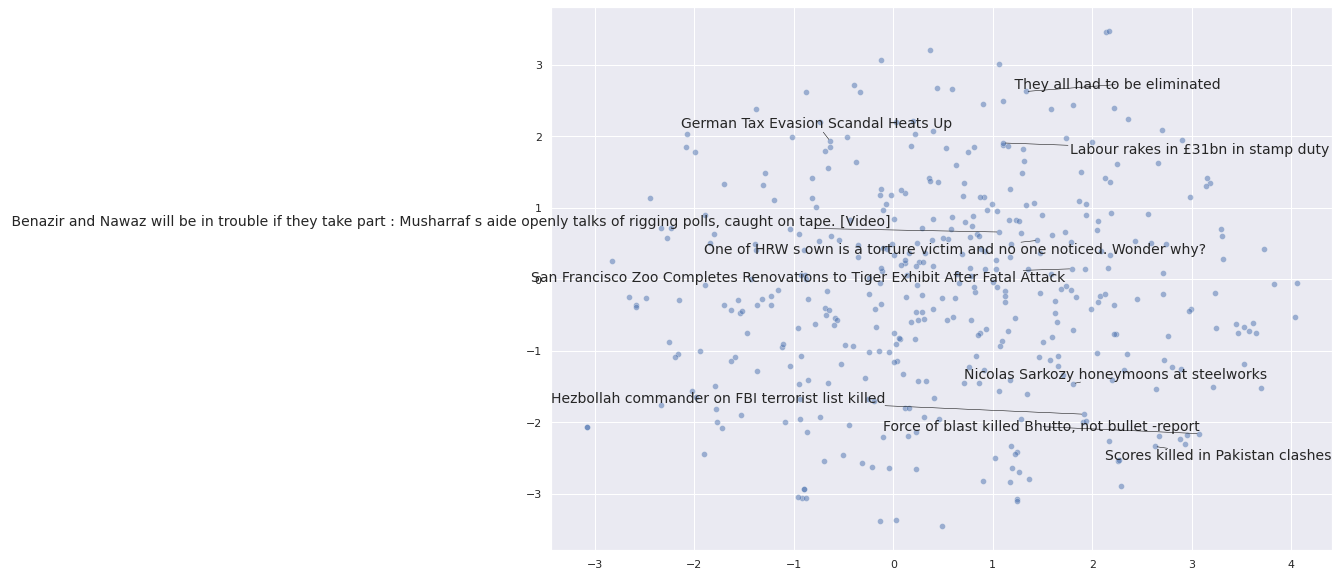

In [ ]:
# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)
tsne_df = tsne.fit_transform(docvec[:400])
fig, ax = plt.subplots(figsize = (14, 10))
sns.scatterplot(tsne_df[:, 0], tsne_df[:, 1], alpha = 0.5)
texts = []
titles_to_plot = list(np.arange(0, 400, 40))
for title in titles_to_plot: texts.append(plt.text(tsne_df[title, 0], tsne_df[title, 1], titles_list[title], fontsize = 14))
adjust_text(texts, force_points = 0.4, force_text = 0.4,expand_points = (2,1), expand_text = (1,2), arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))


# **5. Topic Modeling**

Topic Modeling(Statistical Modeling) is used to help understand the abstract topics that occur in datasets. **Latent Dirichlet Allocation (LDA)** is one such technique which helps classify text content in a document to a particular topic. The process involves building a topic for a document model, words for topic model which is designed as Dirichlet distributions. 

In [ ]:
sample = text.sample(frac=0.1) 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
cv = CountVectorizer(analyzer = text_process)
text_matrix = cv.fit_transform(sample)


In [ ]:
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
n_topics = 8
lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='online', 
                                          random_state=0, verbose=0)
lda_topic_matrix = lda_model.fit_transform(text_matrix)
lda_keys = lda_topic_matrix.argmax(axis=1).tolist()
count_pairs = Counter(lda_keys).items()
categlda_categoriesories = [pair[0] for pair in count_pairs]
lda_counts = [pair[1] for pair in count_pairs]
top_n_words_lda = get_top_n_words(10, lda_keys, text_matrix, cv)

for i in range(len(top_n_words_lda)):
    print("Topic {}: ".format(i+1), top_n_words_lda[i])

Topic 1:  korea north china government say ban german us germany south
Topic 2:  china us minister saudi say arabia prime sea uk south
Topic 3:  say kill us attack state syria force china president report
Topic 4:  world news say iran india nuclear bbc china bank global
Topic 5:  police protest say arrest court kill call charge right case
Topic 6:  russia say syria us new ukraine eu military gaza strike
Topic 7:  kill people un die years say turkey chinese bomb show
Topic 8:  us say israel new find attack war russia get world


# **6.Regression**

We can use Linear Regression to predict the number of upVotes based on titles. 

In [ ]:
df_concat = df[df['up_votes']<20000]

In [ ]:
df_concat = df_concat[['title', 'over_18', 'day_of_week_num','year', 'month', 'day', \
      'weekend', 'years_to_now','day_time','author_total_posts','title_length','places','up_votes']]

In [ ]:
vectors = pd.DataFrame(docvec)
vectors['title'] = titles_left
main = pd.concat((vectors, df_concat), axis=1)
main.dropna(axis=0, inplace=True)
main.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,title,title,over_18,day_of_week_num,year,month,day,weekend,years_to_now,day_time,author_total_posts,title_length,places,up_votes
0,-0.045776,0.086182,0.162781,0.033356,-0.012695,0.103027,0.002197,-0.133911,-0.05481,0.18335,-0.049713,-0.270142,-0.055603,0.130859,-0.092407,0.072205,-0.114746,0.111816,-0.006165,-0.157471,0.119263,-0.024414,0.170532,-0.053818,-0.076233,0.110626,-0.124817,-0.161011,0.007629,-0.083649,-0.135437,0.111767,-0.179321,-0.047241,-0.163696,0.163635,-0.129532,0.118958,0.070847,0.083527,...,0.082684,-0.090454,0.000488,-0.137451,-0.047852,0.017944,0.005096,0.036469,-0.076904,0.071594,-0.122314,-0.128113,0.02832,0.109131,0.040222,-0.064575,0.0,0.026855,-0.181274,0.09668,-0.165955,0.028076,-0.069458,-0.108643,-0.016647,0.120659,Scores killed in Pakistan clashes,Scores killed in Pakistan clashes,0.0,4.0,2008.0,1.0,25.0,0.0,13.243836,3.568333,50.0,5.0,1.0,3.0


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
def model_diagnostics(model, pr=True):
    y_predicted = model.predict(X_val)
    r2 = r2_score(y_val, y_predicted)
    mse = mean_squared_error(y_val, y_predicted)
    mae = mean_absolute_error(y_val, y_predicted)
    if pr:
        print(f"R-Sq: {r2:.4}")
        print(f"RMSE: {np.sqrt(mse)}")
        print(f"MAE: {mae}")

In [ ]:
from sklearn.model_selection import train_test_split
X=main.drop(columns=['up_votes','title'])
y=main['up_votes']
X_train, X_val, y_train, y_val = train_test_split(X, y,test_size=0.1,random_state=101)

In [ ]:
reg = LinearRegression().fit(X_train, y_train)
model_diagnostics(reg)

R-Sq: 0.01724
RMSE: 554.8813009641437
MAE: 189.97354044082957


**Conclusions**

Many conclusions can be drawn from this NLP analyis. Distribution of News vs Time: It can be observed that users access news articles online evidenced with the increase in the number of upVotes. It can also be oberved that there were a lot of terror attacks that happened between 2008 to 2016 which was deduced from Bag-of-Words model.The Linear Regression did not perform that well. Future work can involve Tree-based ensemble classifier.


**Future Work**
1. We can perform sentiment analysis on the title to test accurate content of the news and also maybe to certain extent could help determine it's influence on the number of upvotes.
2. LSTM model can be used for regression analysis as it defintitely provides faster processing time and performance.  